<a href="https://colab.research.google.com/github/ahmadcah/project_pembelajaran_mesin_2018-198/blob/main/GoogleColab/trainPlacesModelTugasCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf /content/p365s

In [ ]:
!rm -rf /content/places365_standard

In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [1]:
import tarfile

tar = tarfile.open("/content/drive/MyDrive/Data/places365standard_easyformat.tar", "r:")
tar.extractall(path='/content')
tar.close()

In [2]:
import os

def count_file(target):
  totalImageFile = 0
  for f in os.listdir(target):
    for i in os.listdir(target+"/"+f):
      totalImageFile +=1
  print(totalImageFile)

In [3]:
count_file("/content/places365_standard/train")
count_file("/content/places365_standard/val")

1803460
36500


In [ ]:
print(1803460+36500)

1839960


In [ ]:
total = 1839960
train = int(total*0.80)
valid = int(total*0.19)
test = int(total*0.01)
print("total: ",total,"train: ",train,"valid: ",valid,"test: ",test)

total:  1839960 train:  1471968 valid:  349592 test:  18399


In [4]:
import shutil
valF = "/content/places365_standard/val"
for f in os.listdir(valF):
  t = valF+"/"+f
  for i in os.listdir(t):
    original = t+"/"+i
    target = '/content/places365_standard/train/'+f+"/"+i
    shutil.move(original,target)

In [ ]:
count_file("/content/places365_standard/train")
count_file("/content/places365_standard/val")

1839960
0


In [5]:
root = "/content/p365s"
train_dir = "/content/p365s/train"
valid_dir = "/content/p365s/valid"
testi_dir = "/content/p365s/testing" 
os.mkdir(root)
os.mkdir(train_dir)
os.mkdir(valid_dir)
os.mkdir(testi_dir)
for i in os.listdir("/content/places365_standard/train"):
  os.mkdir(train_dir+"/"+i)
  os.mkdir(valid_dir+"/"+i)
  os.mkdir(testi_dir+"/"+i)

In [ ]:
print(len(os.listdir(train_dir)))
print(len(os.listdir(valid_dir)))
print(len(os.listdir(testi_dir)))

365
365
365


In [6]:
import random

def split_data(SOURCE, TRAINING, VALIDATION, TESTING, VAL_SIZE, TEST_SIZE):
    l = len(os.listdir(SOURCE))
    VAL_limit = int(l * VAL_SIZE)
    TEST_limit = int(l * TEST_SIZE)
    for i, f in enumerate(random.sample(os.listdir(SOURCE), l)):
        if os.path.getsize(SOURCE + "/" + f) > 0:
            if i < TEST_limit:
                shutil.move(SOURCE + "/" + f, TESTING + "/" + f)
            elif i >= TEST_limit and i < VAL_limit+TEST_limit:
                shutil.move(SOURCE + "/" + f, VALIDATION + "/" + f)
            else:
              shutil.move(SOURCE + "/" + f, TRAINING + "/" + f)
        else:
            print(f + " is zero length, so ignoring")

In [7]:
roots = "/content/places365_standard/train"
for f in os.listdir(roots):
  SOURCE = roots+"/"+f
  TRAINING = train_dir+"/"+f
  VALIDATION = valid_dir+"/"+f
  TESTING = testi_dir+"/"+f
  VAL_SIZE = 0.19
  TEST_SIZE = 0.01
  split_data(SOURCE, TRAINING, VALIDATION, TESTING, VAL_SIZE, TEST_SIZE)

In [8]:
count_file("/content/places365_standard/train")
count_file("/content/places365_standard/val")

0
0


In [16]:
import tensorflow as tf

bs = 64

training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(256,256),
	class_mode='categorical',
  batch_size=bs)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
	valid_dir,
	target_size=(256,256),
	class_mode='categorical',
  batch_size=bs)

testing_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

testing_generator = validation_datagen.flow_from_directory(
	testi_dir,
	target_size=(256,256),
	class_mode='categorical',
  batch_size=bs)

Found 1471994 images belonging to 365 classes.
Found 349578 images belonging to 365 classes.
Found 18388 images belonging to 365 classes.


In [17]:
ltc = len(train_generator.classes) 
lvc = len(validation_generator.classes)
ltsc = len(testing_generator.classes) 
totalgen = ltc + lvc + ltsc
print("gen total: ",totalgen)
print("train: ",ltc/totalgen*100,"%")
print("valid: ",lvc/totalgen*100,"%")
print("testi: ",ltsc/totalgen*100,"%")

gen total:  1839960
train:  80.00141307419727 %
valid:  18.999217374290744 %
testi:  0.9993695515119894 %


In [18]:
total = 1839960
train = int(total*0.80)
valid = int(total*0.19)
test = int(total*0.01)
print("total: ",total,"train: ",train,"valid: ",valid,"test: ",test)

total:  1839960 train:  1471968 valid:  349592 test:  18399


In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(365, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 252, 252, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 124, 124, 128)     73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 122, 122, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 61, 61, 128)      0         
 2D)                                                  

In [20]:
callbacksEarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
class CallbackAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        if logs.get('acc') > 0.98 and logs.get('val_acc') > 0.98:
            self.model.stop_training = True

In [21]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [ ]:
spe = ltc //bs
print(spe)
vs = len(validation_generator.classes)//bs
print(vs)

45999
10924


In [22]:
history = model.fit(train_generator, 
                    epochs=100, 
                    steps_per_epoch=256,
                    validation_data = validation_generator, 
                    verbose = 1, 
                    validation_steps=128,
                    callbacks=[CallbackAccuracy(),callbacksEarlyStopping])

Epoch 1/100
256/256 [==============================] - 297s 1s/step - loss: 452.7677 - acc: 0.0036 - val_loss: 5.8994 - val_acc: 0.0029
Epoch 2/100
256/256 [==============================] - 292s 1s/step - loss: 5.8995 - acc: 0.0020 - val_loss: 5.8997 - val_acc: 0.0033
Epoch 3/100
256/256 [==============================] - 295s 1s/step - loss: 5.8997 - acc: 0.0028 - val_loss: 5.8993 - val_acc: 0.0028
Epoch 4/100
256/256 [==============================] - 293s 1s/step - loss: 5.8996 - acc: 0.0024 - val_loss: 5.8993 - val_acc: 0.0032
Epoch 5/100
256/256 [==============================] - 285s 1s/step - loss: 5.8993 - acc: 0.0028 - val_loss: 5.8989 - val_acc: 0.0042
Epoch 6/100
256/256 [==============================] - 287s 1s/step - loss: 5.8992 - acc: 0.0031 - val_loss: 5.9001 - val_acc: 0.0024
Epoch 7/100
256/256 [==============================] - 291s 1s/step - loss: 5.8998 - acc: 0.0027 - val_loss: 5.8994 - val_acc: 0.0026
Epoch 8/100
256/256 [==============================] - 289s 

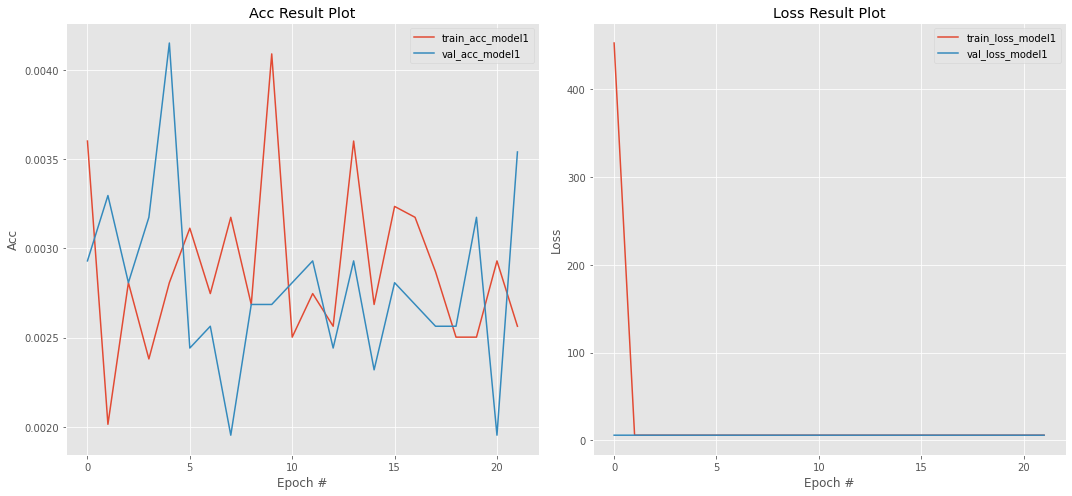

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axes[0].plot(np.arange(0, 22), history.history["acc"], label="train_acc_model1")
axes[0].plot(np.arange(0, 22), history.history["val_acc"], label="val_acc_model1")
axes[0].legend()
axes[1].plot(np.arange(0, 22), history.history["loss"], label="train_loss_model1")
axes[1].plot(np.arange(0, 22), history.history["val_loss"], label="val_loss_model1")
axes[1].legend()
plt.setp(axes[0],title='Acc Result Plot', xlabel="Epoch #", ylabel="Acc")
plt.setp(axes[1],title='Loss Result Plot', xlabel="Epoch #", ylabel="Loss")
fig.tight_layout()

In [25]:
label = list(validation_generator.class_indices.keys())

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
num_of_test_samples = len(validation_generator.filenames)

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('\nConfusion Matrix\n')
print(confusion_matrix(validation_generator.classes, y_pred))
print('\n\nClassification Report\n')
print(classification_report(validation_generator.classes, y_pred, target_names=label))


Confusion Matrix

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Classification Report



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                  airfield       0.00      0.00      0.00       969
            airplane_cabin       0.00      0.00      0.00       969
          airport_terminal       0.00      0.00      0.00       969
                    alcove       0.00      0.00      0.00       969
                     alley       0.00      0.00      0.00       969
              amphitheater       0.00      0.00      0.00       969
          amusement_arcade       0.00      0.00      0.00       969
            amusement_park       0.00      0.00      0.00       969
apartment_building-outdoor       0.00      0.00      0.00       969
                  aquarium       0.00      0.00      0.00       969
                  aqueduct       0.00      0.00      0.00       969
                    arcade       0.00      0.00      0.00       969
                      arch       0.00      0.00      0.00       969
  archaelogical_excavation       0.00      0.00